In [25]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [26]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [27]:
drivers_df = pd.read_pickle('../output/given_improvements_drivers.pkl')
riders_df = pd.read_pickle('../output/given_improvements_riders.pkl')

im_drivers_df = pd.read_pickle('../output/given_improvements_2_drivers.pkl')
im_riders_df = pd.read_pickle('../output/given_improvements_2_riders.pkl')


# im_drivers_df = pd.read_pickle('../output/waiting_points_drivers.pkl')
# im_riders_df = pd.read_pickle('../output/waiting_points_riders.pkl')

# br_drivers_df = pd.read_pickle('../output/drivers_break_drivers.pkl')
# br_riders_df = pd.read_pickle('../output/drivers_break_riders.pkl')

# ps_drivers_df = pd.read_pickle('../output/pre_search_drivers.pkl')
# ps_riders_df = pd.read_pickle('../output/pre_search_riders.pkl')

# ff_drivers_df = pd.read_pickle('../output/improved_drivers.pkl')
# ff_riders_df = pd.read_pickle('../output/improved_riders.pkl')

In [28]:
concurrent_df = pd.read_csv('../output/given_improvements_concurrent_data.csv')
im_concurrent_df = pd.read_csv('../output/given_improvements_concurrent_data.csv') 

In [29]:
def abandon_overtime(riders_df):
    temp_df = riders_df.copy()

    # Remove 'waiting' status
    temp_df = temp_df[~temp_df['status'].isin(['waiting', 'riding'])]
    temp_df['time'] = temp_df['become_available']
    
    
    custom_palette = {
        'matched': '#4CAF50',  # Vibrant Green
        'abandoned': '#FF5252',            # Bright Red
    }
    
    # Define equal-sized time intervals
    time_min, time_max = temp_df['time'].min(), temp_df['time'].max()
    bin_edges = list(range(int(time_min), int(time_max) + 6, 5000))  # Creating bins with a max span of 5
    temp_df['time_interval'] = pd.cut(temp_df['time'], bins=bin_edges, labels=[f"{bin_edges[i]}-{bin_edges[i+1]-1}" for i in range(len(bin_edges)-1)], include_lowest=True)
    
    # Combine 'reached_destination' and 'transit' into 'matched'
    temp_df['status'] = temp_df['status'].replace({'reached_destination': 'matched', 'transit': 'matched'})
    
    # Calculate rate of each status over time intervals
    status_counts = temp_df.groupby(['time_interval', 'status']).size().unstack(fill_value=0)
    status_rates = status_counts.div(status_counts.sum(axis=1), axis=0)
    
    # Set seaborn style
    sns.set_theme(style="whitegrid")
    
    # Create the line plot for rates
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=status_rates, markers=True, palette=custom_palette)
    
    # Labels and title
    plt.xlabel("Time Interval", color='darkgray')
    plt.ylabel("Rate", color='darkgray')
    plt.title("Rate of Each Status Over Time Intervals", color='darkgray')
    plt.xticks(rotation=90, color='darkgray')
    plt.yticks(color='darkgray')
    
    # Show the plot
    plt.show()

In [30]:
def riders_analysis(riders_df):
    """
    Perform overall analysis of the riders data and generate multiple distribution plots.
    
    This analysis includes:
      - Distribution of rider statuses.
      - Distributions of waiting time, wait-till-match time, and pickup-wait time.
      - Comparison of trip-related metrics.
    
    Returns:
      - The original riders_df.
      - A filtered DataFrame of riders who reached their destination with computed metrics.
    """
    # For status counts, we can use a countplot that mimics a distribution style
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(8, 5))
    # Using countplot which fits well with discrete data
    custom_palette = {
        'reached_destination': '#4CAF50',  # Vibrant Green
        'abandoned': '#FF5252',            # Bright Red
        'riding': '#42A5F5', 
        'matched': '#42A5F5',              # Vivid Blue
        'waiting': '#FFA726'               # Bright Orange
    }
    ax = sns.countplot(x='status', data=riders_df, palette=custom_palette, stat='count')
    for container in ax.containers:
        ax.bar_label(container)
    plt.xlabel("Status", color='black')
    plt.ylabel("Count", color='black')
    plt.title("Distribution of Rider Statuses", color='black')
    plt.xticks(rotation=15, color='black')
    plt.tight_layout()
    plt.show()
    
    # Filter riders who reached destination and compute time metrics
    filtered_riders_df = riders_df.loc[riders_df['status'] == 'reached_destination'].copy()
    filtered_riders_df.loc[:, 'total_system_time'] = (
        filtered_riders_df['destination_time'] - filtered_riders_df['become_available']
    )
    filtered_riders_df.loc[:, 'total_trip_time'] = (
        filtered_riders_df['destination_time'] - filtered_riders_df['pick_up_time']
    )
    filtered_riders_df.loc[:, 'waiting_time'] = (
        filtered_riders_df['pick_up_time'] - filtered_riders_df['become_available']
    )
    filtered_riders_df.loc[:, 'pick_up_wait_time'] = (
        filtered_riders_df['waiting_time'] - filtered_riders_df['wait_till_match']
    )
    
    # Distribution plots for rider time metrics using sns.histplot (matching driver style)
    plt.figure(figsize=(8, 5))
    sns.histplot(filtered_riders_df['waiting_time'], bins=30, kde=True, color='#81C784')
    plt.title("Distribution of Waiting Time")
    plt.xlabel("Waiting Time")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(8, 5))
    sns.histplot(filtered_riders_df['wait_till_match'], bins=30, kde=True, color='#FF7043')
    plt.title("Distribution of Wait Till Match Time")
    plt.xlabel("Wait Till Match Time")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(8, 5))
    sns.histplot(filtered_riders_df['pick_up_wait_time'], bins=30, kde=True, color='#42A5F5')
    plt.title("Distribution of Pick Up Wait Time")
    plt.xlabel("Pick Up Wait Time")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()
    
    # For trip metrics, we can show a boxplot of the average times
    avg_patience_time = filtered_riders_df['patience_time'].mean()
    avg_wait_till_match_time = filtered_riders_df['wait_till_match'].mean()
    avg_pick_up_wait_time = filtered_riders_df['pick_up_wait_time'].mean()
    avg_trip_time = filtered_riders_df['total_trip_time'].mean()
    avg_waiting_time = filtered_riders_df['waiting_time'].mean()
    
    metrics = ['Mean Patience Time', 'Mean Wait Till Match Time', 'Mean Pick Up Time', 'Mean Trip Time']
    values = [avg_patience_time, avg_wait_till_match_time, avg_pick_up_wait_time, avg_trip_time]
    # Using a bar plot for average metrics, styled similarly
    plt.figure(figsize=(8, 6))
    sns.barplot(x=metrics, y=values, palette=['#FFB74D', '#81C784', '#64B5F6', '#BA68C8'])
    plt.xlabel("Metrics")
    plt.ylabel("Time (Minutes)")
    plt.title("Average Rider Trip Times")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

    n_abandon = riders_df[riders_df['status'] == 'abandoned']['id'].count();
    total_riders = riders_df.shape[0]
    print('############# Rider statisfaction #######################')
    print(f'The system abandonment rates {n_abandon /total_riders}')
    abandon_overtime(riders_df)
    print('### wait Time ###')
    print(f'The system average riders wait time {avg_waiting_time}')
    print('### wait for match ###')
    print(f'The system wait until match time {filtered_riders_df['wait_till_match'].mean()}')
    print('### wait for pick up ###')
    print(f'The system wait for pick up time {filtered_riders_df['pick_up_wait_time'].mean()}')

    
    return riders_df, filtered_riders_df


In [31]:
def drivers_analysis(drivers_df):
    """
    Perform overall analysis of driver data for offline drivers.
    
    This analysis includes:
      - Calculation of average earnings per hour and total jobs time.
      - Breakdown of distances (pickup, dropoff, idling, total driving distance).
      - Earnings breakdown including profit (earnings minus fuel cost) with distribution plots.
      - Time breakdown for drivers, plotting pick up time, dropoff time, and idling time together.
      - A bar graph of average drivers' distance and earnings metrics.
      - Printing of key average values.
      - Visualization of distributions for other key metrics.
    
    Returns:
      - The original drivers_df.
      - A filtered DataFrame of offline drivers with computed metrics.
    """
    filtered_drivers_df = drivers_df.loc[drivers_df['status'] == 'offline'].copy()
    
    # Compute total jobs time and average earnings per hour
    filtered_drivers_df.loc[:, 'total_jobs_time'] = (
        filtered_drivers_df['actual_offline_time'] - filtered_drivers_df['become_available']
    )
    filtered_drivers_df.loc[:, 'avg_earning_per_hours'] = (
        filtered_drivers_df['earnings'] / filtered_drivers_df['total_jobs_time']
    )
    
    # Compute total driving distance if available
    if {'total_pickup_distance', 'total_dropoff_distance', 'total_idling_distance'}.issubset(filtered_drivers_df.columns):
        filtered_drivers_df.loc[:, 'total_distance'] = (
            filtered_drivers_df['total_pickup_distance'] +
            filtered_drivers_df['total_dropoff_distance'] +
            filtered_drivers_df['total_idling_distance']
        )
    
    # Compute profit if fuel cost is available
    if 'fuel_cost' in filtered_drivers_df.columns:
        filtered_drivers_df.loc[:, 'profit'] = filtered_drivers_df['earnings'] - filtered_drivers_df['fuel_cost']
    
    # Compute resting time (non-driving) if total driving time is provided.
    if 'total_driving_time' in filtered_drivers_df.columns:
        filtered_drivers_df.loc[:, 'resting_time'] = (
            filtered_drivers_df['total_jobs_time'] - filtered_drivers_df['total_driving_time']
        )
    
    # --- Earnings Breakdown ---
    print("----- Driver Earnings Analysis -----")
    print(filtered_drivers_df[['earnings', 'avg_earning_per_hours']].describe())
    if 'profit' in filtered_drivers_df.columns:
        print("\nProfit Analysis:")
        print(filtered_drivers_df['profit'].describe())
    
    # Distribution of Average Earnings per Hour
    plt.figure(figsize=(8, 5))
    sns.histplot(filtered_drivers_df['avg_earning_per_hours'], bins=30, kde=True, color='#42A5F5')
    plt.title("Distribution of Average Earnings per Hour")
    plt.xlabel("Average Earnings per Hour")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()
    
    # Distribution of Total Earnings
    plt.figure(figsize=(8, 5))
    sns.histplot(filtered_drivers_df['earnings'], bins=30, kde=True, color='#FFA726')
    plt.title("Distribution of Driver Earnings")
    plt.xlabel("Earnings")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()
    
    # Distribution of Fuel Cost (if available)
    if 'fuel_cost' in filtered_drivers_df.columns:
        plt.figure(figsize=(8, 5))
        sns.histplot(filtered_drivers_df['fuel_cost'], bins=30, kde=True, color='#FFCC80')
        plt.title("Distribution of Fuel Cost")
        plt.xlabel("Fuel Cost")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()
    
    # Distribution of Profit (if computed)
    if 'profit' in filtered_drivers_df.columns:
        plt.figure(figsize=(8, 5))
        sns.histplot(filtered_drivers_df['profit'], bins=30, kde=True, color='#66BB6A')
        plt.title("Distribution of Profit")
        plt.xlabel("Profit")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()
    
    # Earnings Composition Breakdown (if all components are available)
    if {'earnings', 'fuel_cost', 'profit'}.issubset(filtered_drivers_df.columns):
        melt_earnings = filtered_drivers_df.melt(value_vars=['earnings', 'fuel_cost', 'profit'],
                                                 var_name='Earnings Component', value_name='Amount')
        plt.figure(figsize=(8, 5))
        sns.boxplot(x='Earnings Component', y='Amount', data=melt_earnings, palette='Set2')
        plt.title("Earnings Breakdown: Earnings, Fuel Cost, and Profit")
        plt.xlabel("Component")
        plt.ylabel("Amount")
        plt.tight_layout()
        plt.show()
    
    # --- Time Breakdown ---
    # First, compute total idling time if not directly available.
    if {'total_time', 'total_pickup_time', 'total_dropoff_time'}.issubset(filtered_drivers_df.columns):
        filtered_drivers_df.loc[:, 'total_idling_time'] = (
            filtered_drivers_df['total_time'] - filtered_drivers_df['total_pickup_time'] - filtered_drivers_df['total_dropoff_time']
        )
    
    time_cols = []
    if 'total_pickup_time' in filtered_drivers_df.columns:
        time_cols.append('total_pickup_time')
    if 'total_dropoff_time' in filtered_drivers_df.columns:
        time_cols.append('total_dropoff_time')
    if 'total_waiting_point_travel_time' in filtered_drivers_df.columns:
        time_cols.append('total_waiting_point_travel_time')
        if 'total_idling_time' in filtered_drivers_df.columns:
            filtered_drivers_df.loc[:, 'total_idling_time'] = filtered_drivers_df['total_idling_time'] - filtered_drivers_df['total_waiting_point_travel_time']
    if 'total_idling_time' in filtered_drivers_df.columns:
        time_cols.append('total_idling_time')
    
    print("Time columns for breakdown:", time_cols)
    
    if time_cols:
        plt.figure(figsize=(8, 5))
        melt_time = filtered_drivers_df.melt(value_vars=time_cols, var_name='Time Category', value_name='Time')
        sns.boxplot(x='Time Category', y='Time', data=melt_time, palette='Set3')
        plt.title("Drivers Time Breakdown: Pick Up, Dropoff, and Idling Times")
        plt.xlabel("Time Category")
        plt.ylabel("Time")
        plt.tight_layout()
        plt.show()
    
    # Plot distribution of Resting Time if computed
    if 'resting_time' in filtered_drivers_df.columns:
        plt.figure(figsize=(8, 5))
        sns.histplot(filtered_drivers_df['resting_time'], bins=30, kde=True, color='#81C784')
        plt.title("Distribution of Resting Time")
        plt.xlabel("Resting Time")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()
    
    # --- Distance Breakdown ---
    # Boxplot for individual distance components
    if {'total_pickup_distance', 'total_dropoff_distance', 'total_idling_distance'}.issubset(filtered_drivers_df.columns):
        plt.figure(figsize=(8, 5))
        distance_cols = ['total_pickup_distance', 'total_dropoff_distance', 'total_idling_distance']
        melt_distance = filtered_drivers_df.melt(value_vars=distance_cols, var_name='Distance Category', value_name='Distance')
        sns.boxplot(x='Distance Category', y='Distance', data=melt_distance, palette='Set2')
        plt.title("Distance Breakdown: Pickup, Dropoff, and Idling Distances")
        plt.xlabel("Distance Category")
        plt.ylabel("Distance")
        plt.tight_layout()
        plt.show()
    
    # Histogram for Total Driving Distance if computed
    if 'total_distance' in filtered_drivers_df.columns:
        plt.figure(figsize=(8, 5))
        sns.histplot(filtered_drivers_df['total_distance'], bins=30, kde=True, color='#90CAF9')
        plt.title("Distribution of Total Driving Distance")
        plt.xlabel("Total Driving Distance")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

    metrics = ['Mean Pickup Distance', 'Mean Dropoff Distance', 'Mean Waiting Points Distance']
    values = [filtered_drivers_df['total_distance'].mean(), filtered_drivers_df['total_dropoff_distance'].mean(), filtered_drivers_df['total_idling_distance'].mean()]
    # Using a bar plot for average metrics, styled similarly
    plt.figure(figsize=(8, 6))
    sns.barplot(x=metrics, y=values, palette=['#FFB74D', '#81C784', '#64B5F6', '#BA68C8'])
    plt.xlabel("Distances")
    plt.ylabel("Distance (Miles)")
    plt.title("Average Drivers Distance")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()
    
    # --- Bar Graph of Averages ---
    # Compute average metrics for distances and earnings and print them
    metrics = []
    values = []
    if 'earnings' in filtered_drivers_df.columns:
        avg_earning = filtered_drivers_df['earnings'].mean()
        metrics.append("Avg Earning")
        values.append(avg_earning)
        print("Average Earning:", avg_earning)
    
    
    if 'profit' in filtered_drivers_df.columns:
        avg_profit = filtered_drivers_df['profit'].mean()
        metrics.append("Avg Profit")
        values.append(avg_profit)
        print("Average Profit:", avg_profit)
    
    if 'fuel_cost' in filtered_drivers_df.columns:
        avg_fuel_cost = filtered_drivers_df['fuel_cost'].mean()
        metrics.append("Avg Fuel Cost")
        values.append(avg_fuel_cost)
        print("Average Fuel Cost:", avg_fuel_cost)
    
    if metrics:
        plt.figure(figsize=(8, 6))
        sns.barplot(x=metrics, y=values, palette=['#90CAF9', '#FFA726', '#66BB6A', '#FFCC80'][:len(metrics)])
        plt.xlabel("Metrics")
        plt.ylabel("Average Value")
        plt.title("Average Drivers Distance and Earnings Breakdown")
        plt.xticks(rotation=30)
        plt.tight_layout()
        plt.show()
    
    return drivers_df, filtered_drivers_df


In [32]:
def drivers_in_system(df):
    # Define time intervals in 500 increments
    time_intervals = np.arange(0, 10001, 500)
    
    # Ensure all lists have the same length
    drivers_in_system = np.zeros(len(time_intervals))
    drivers_entered = np.zeros(len(time_intervals))
    drivers_exited = np.zeros(len(time_intervals))
    
    for i in range(len(time_intervals) - 1):
        t_start, t_end = time_intervals[i], time_intervals[i + 1]
        in_system = ((df['become_available'] <= t_end) & ((df['offline_time'] > t_end) | (df['offline_time'] == np.inf))).sum()
        entered = ((df['become_available'] >= t_start) & (df['become_available'] < t_end)).sum()
        exited = ((df['offline_time'] >= t_start) & (df['offline_time'] < t_end)).sum()
        
        drivers_in_system[i] = in_system
        drivers_entered[i] = entered
        drivers_exited[i] = exited
    
    # Adjust last element for plotting consistency
    drivers_in_system[-1] = drivers_in_system[-2]
    drivers_entered[-1] = drivers_entered[-2]
    drivers_exited[-1] = drivers_exited[-2]
    
    # Create DataFrame for plotting
    interval_df = pd.DataFrame({
        'Time': time_intervals,
        'drivers in System': drivers_in_system,
        'drivers Entered': drivers_entered,
        'drivers Exited': drivers_exited
    })
    
    # Set seaborn style
    sns.set_theme(style="whitegrid")
    
    # Plot: Number of drivers in the system over time
    plt.figure(figsize=(8, 5))
    sns.lineplot(x='Time', y='drivers in System', data=interval_df, marker='o', label='drivers in System')
    plt.xlabel("Time Interval", color='darkgray')
    plt.ylabel("Number of drivers", color='darkgray')
    plt.title("Number of drivers in the System Over Time", color='darkgray')
    plt.xticks(color='darkgray', rotation=50)
    plt.yticks(color='darkgray')
    plt.legend()
    plt.show()
    
    # Plot: drivers entered and exited the system over time
    plt.figure(figsize=(8, 5))
    sns.lineplot(x='Time', y='drivers Entered', data=interval_df, marker='o', label='drivers Entered')
    sns.lineplot(x='Time', y='drivers Exited', data=interval_df, marker='o', label='drivers Exited')
    plt.xlabel("Time Interval", color='darkgray')
    plt.ylabel("Number of drivers", color='darkgray')
    plt.title("drivers Entering and Exiting the System Over Time", color='darkgray')
    plt.xticks(color='darkgray', rotation=50)
    plt.yticks(color='darkgray')
    plt.legend()
    plt.show()

def riders_in_system(df):
    # Define time intervals in 500 increments
    time_intervals = np.arange(0, 10001, 500)
    
    # Ensure all lists have the same length
    riders_in_system = np.zeros(len(time_intervals))
    riders_entered = np.zeros(len(time_intervals))
    riders_exited = np.zeros(len(time_intervals))
    
    for i in range(len(time_intervals) - 1):
        t_start, t_end = time_intervals[i], time_intervals[i + 1]
        in_system = ((df['become_available'] <= t_end) & ((df['offline_time'] > t_end) | (df['offline_time'] == np.inf))).sum()
        entered = ((df['become_available'] >= t_start) & (df['become_available'] < t_end)).sum()
        exited = ((df['offline_time'] >= t_start) & (df['offline_time'] < t_end)).sum()
        
        riders_in_system[i] = in_system
        riders_entered[i] = entered
        riders_exited[i] = exited
    
    # Adjust last element for plotting consistency
    riders_in_system[-1] = riders_in_system[-2]
    riders_entered[-1] = riders_entered[-2]
    riders_exited[-1] = riders_exited[-2]
    
    # Create DataFrame for plotting
    interval_df = pd.DataFrame({
        'Time': time_intervals,
        'Riders in System': riders_in_system,
        'Riders Entered': riders_entered,
        'Riders Exited': riders_exited
    })
    
    # Set seaborn style
    sns.set_theme(style="whitegrid")
    
    # Plot: Number of riders in the system over time
    plt.figure(figsize=(8, 5))
    sns.lineplot(x='Time', y='Riders in System', data=interval_df, marker='o', label='Riders in System')
    plt.xlabel("Time Interval", color='darkgray')
    plt.ylabel("Number of Riders", color='darkgray')
    plt.title("Number of Riders in the System Over Time", color='darkgray')
    plt.xticks(color='darkgray', rotation=50)
    plt.yticks(color='darkgray')
    plt.legend()
    plt.show()
    
    # Plot: Riders entered and exited the system over time
    plt.figure(figsize=(8, 5))
    sns.lineplot(x='Time', y='Riders Entered', data=interval_df, marker='o', label='Riders Entered')
    sns.lineplot(x='Time', y='Riders Exited', data=interval_df, marker='o', label='Riders Exited')
    plt.xlabel("Time Interval", color='darkgray')
    plt.ylabel("Number of Riders", color='darkgray')
    plt.title("Riders Entering and Exiting the System Over Time", color='darkgray')
    plt.xticks(color='darkgray', rotation=50)
    plt.yticks(color='darkgray')
    plt.legend()
    plt.show()


def concurrent_data(concurrent_df):
    sns.lineplot(data=concurrent_df, x="time", y="concurrent_drivers")
    sns.lineplot(data=concurrent_df, x="time", y="concurrent_riders")
    

def system_analysis(riders_df, drivers_df, concurrent_df):
    drivers_in_system(drivers_df)
    riders_in_system(riders_df)
    concurrent_data(concurrent_df)
    

/tmp/ipykernel_361232/1847652783.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='status', data=riders_df, palette=custom_palette, stat='count')


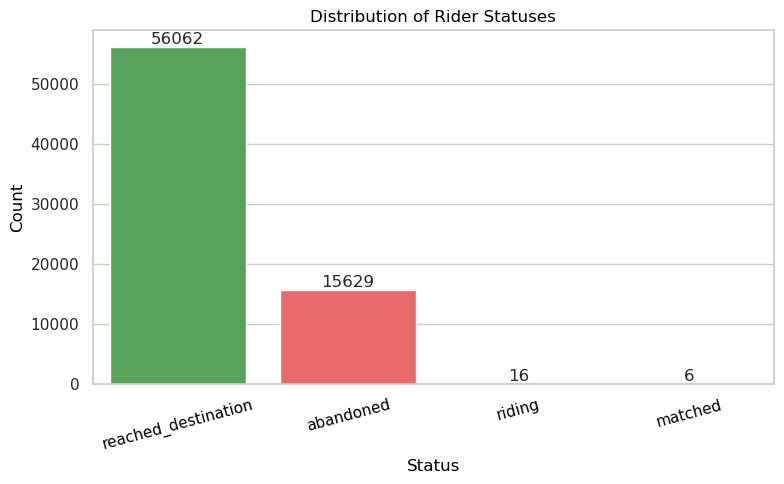

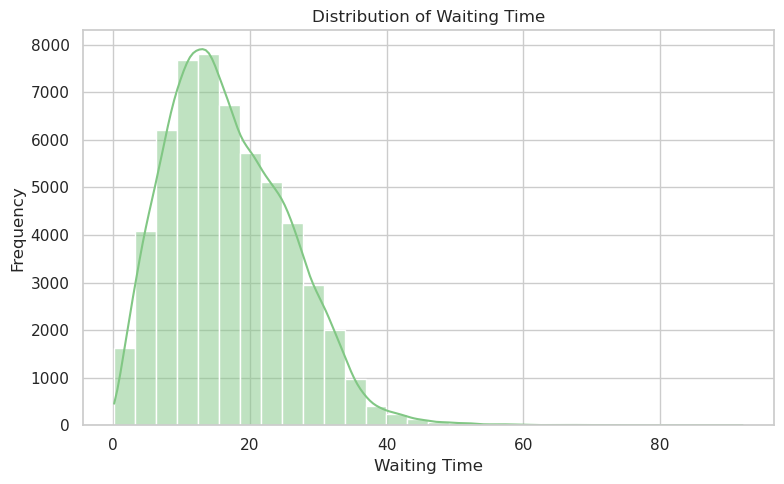

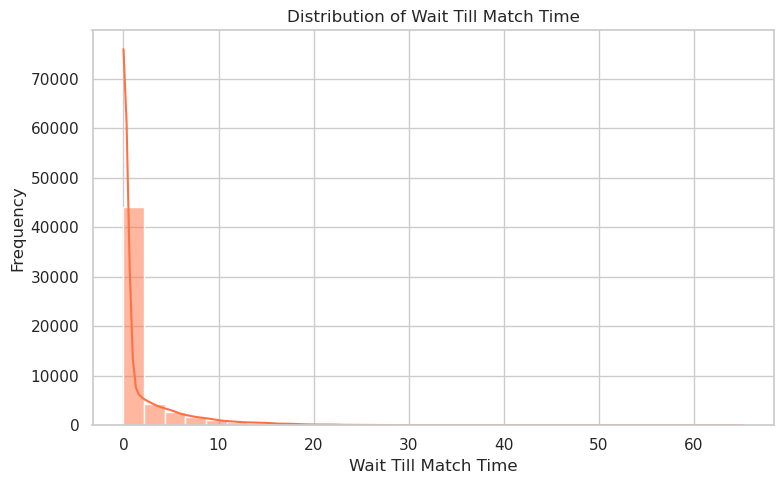

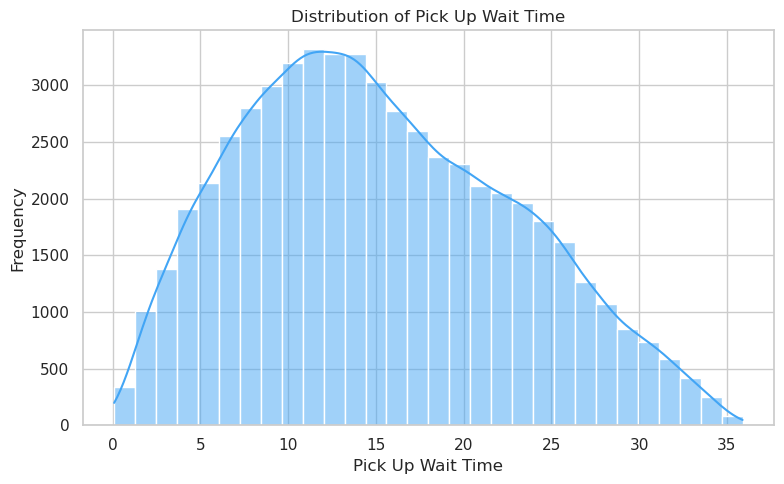

/tmp/ipykernel_361232/1847652783.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette=['#FFB74D', '#81C784', '#64B5F6', '#BA68C8'])


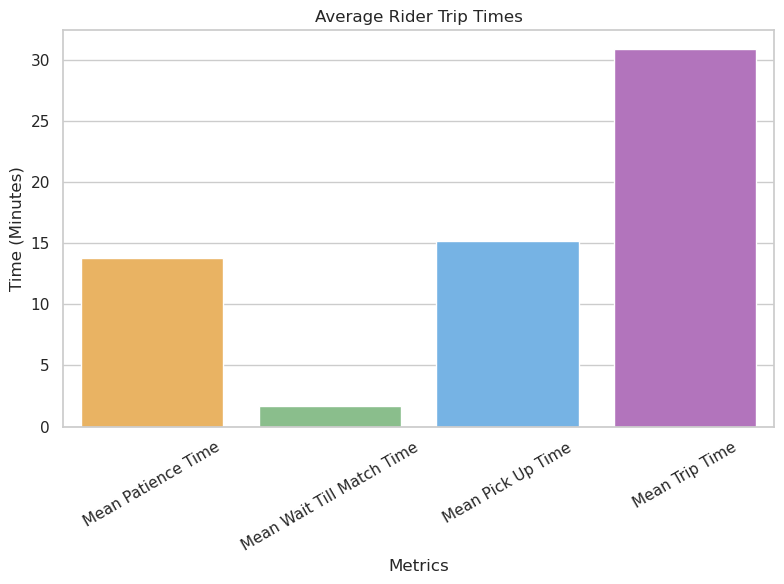

############# Rider statisfaction #######################
The system abandonment rates 0.21793817020623876


/tmp/ipykernel_361232/1964978470.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  status_counts = temp_df.groupby(['time_interval', 'status']).size().unstack(fill_value=0)


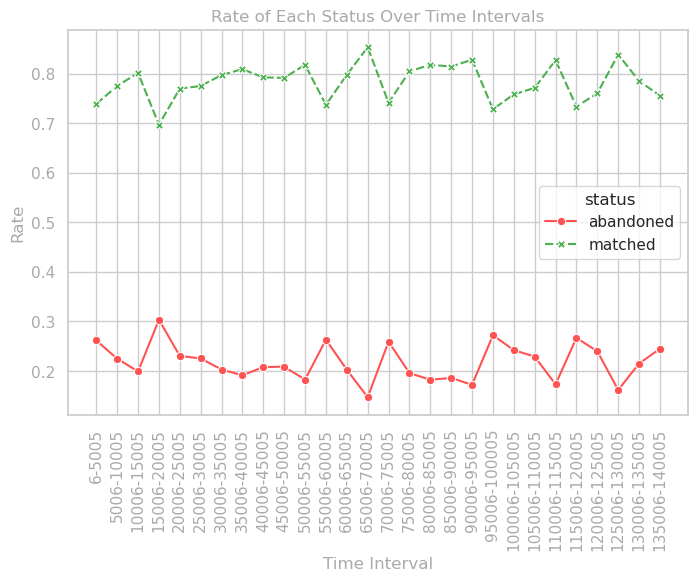

### wait Time ###
The system average riders wait time 16.90644883250889
### wait for match ###
The system wait until match time 1.718863361396267
### wait for pick up ###
The system wait for pick up time 15.187585471112621


In [33]:
riders_df, fitered_riders_df = riders_analysis(riders_df)

/tmp/ipykernel_361232/1847652783.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='status', data=riders_df, palette=custom_palette, stat='count')


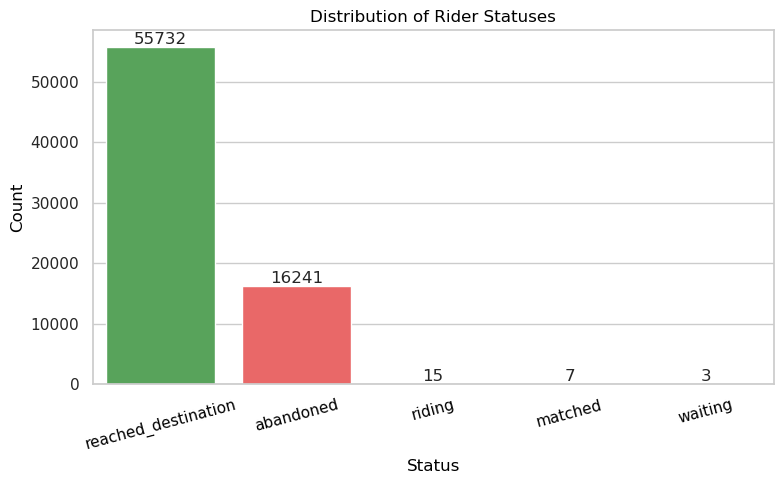

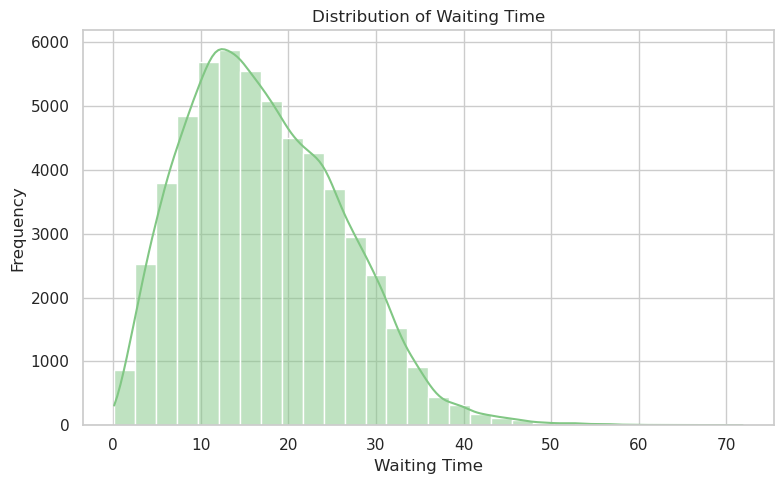

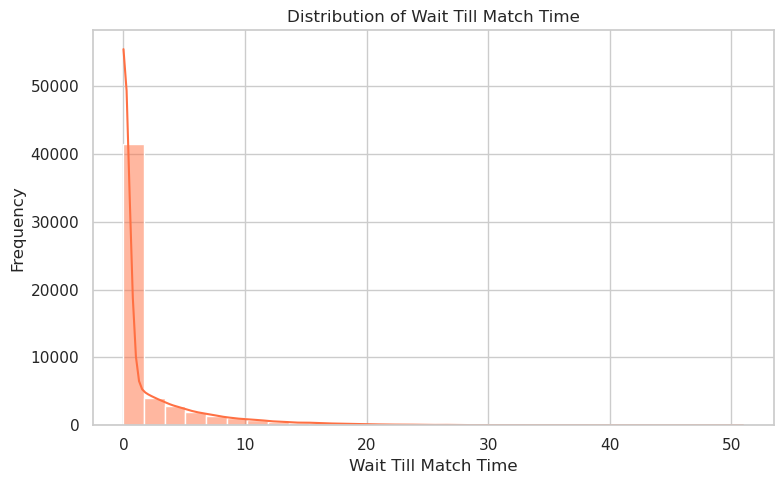

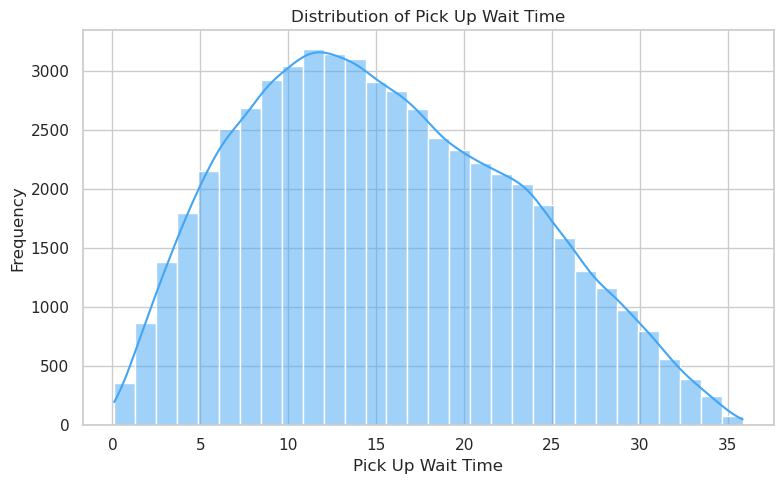

/tmp/ipykernel_361232/1847652783.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette=['#FFB74D', '#81C784', '#64B5F6', '#BA68C8'])


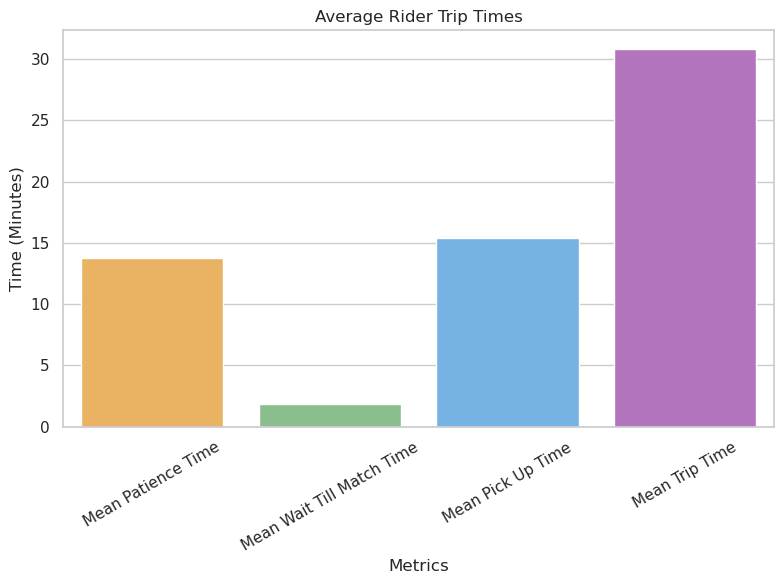

############# Rider statisfaction #######################
The system abandonment rates 0.225575710436401


/tmp/ipykernel_361232/1964978470.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  status_counts = temp_df.groupby(['time_interval', 'status']).size().unstack(fill_value=0)


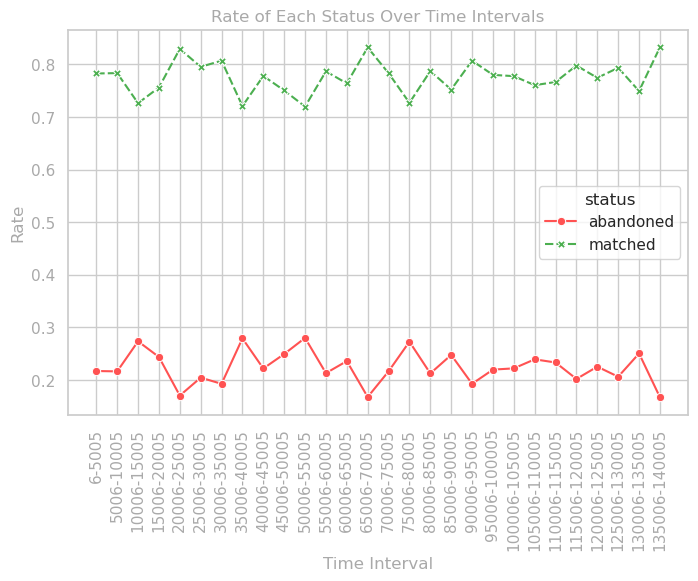

### wait Time ###
The system average riders wait time 17.260941072562122
### wait for match ###
The system wait until match time 1.8715662410030334
### wait for pick up ###
The system wait for pick up time 15.38937483155909


In [34]:
im_riders_df, fitered_im_riders_df = riders_analysis(im_riders_df)

----- Driver Earnings Analysis -----
          earnings  avg_earning_per_hours
count  4081.000000            4081.000000
mean    181.804487               0.445548
std      32.686104               0.056543
min      42.179032               0.133826
25%     158.894131               0.415148
50%     181.673590               0.450784
75%     204.967646               0.483930
max     278.849392               0.613498

Profit Analysis:
count    4081.000000
mean      156.179181
std        29.059173
min        34.196012
25%       135.658795
50%       155.950696
75%       176.349602
max       244.571771
Name: profit, dtype: float64


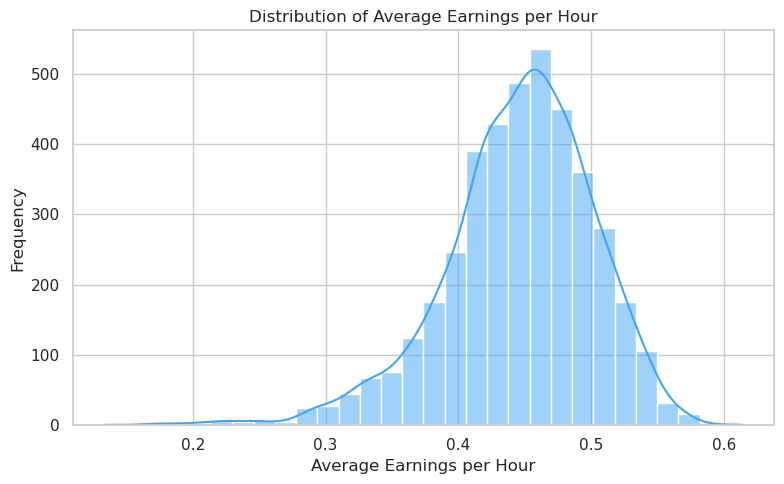

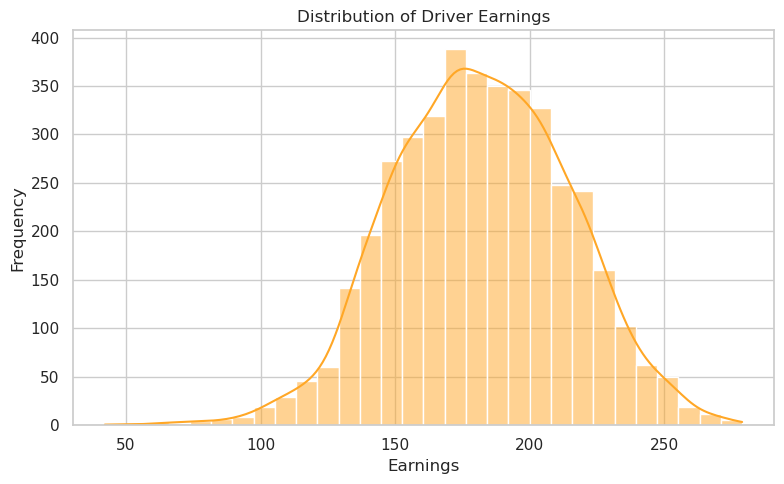

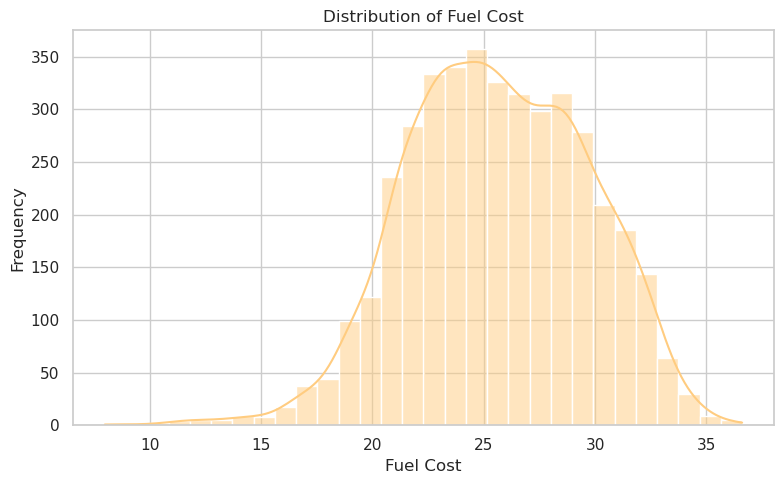

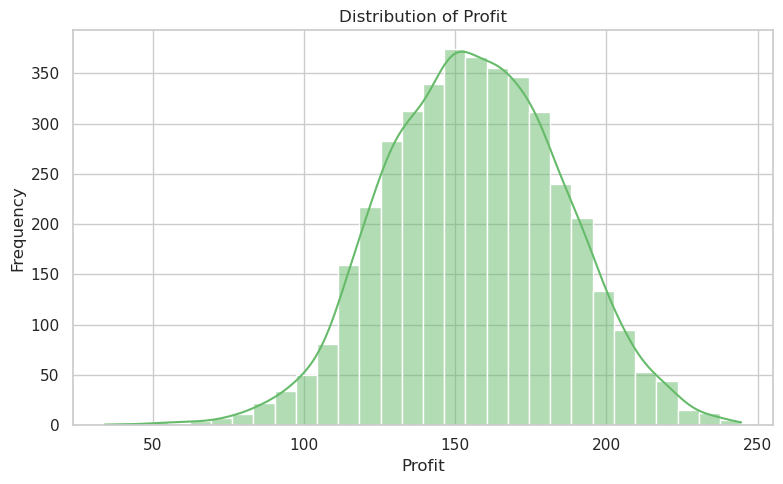

/tmp/ipykernel_361232/4056311542.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Earnings Component', y='Amount', data=melt_earnings, palette='Set2')


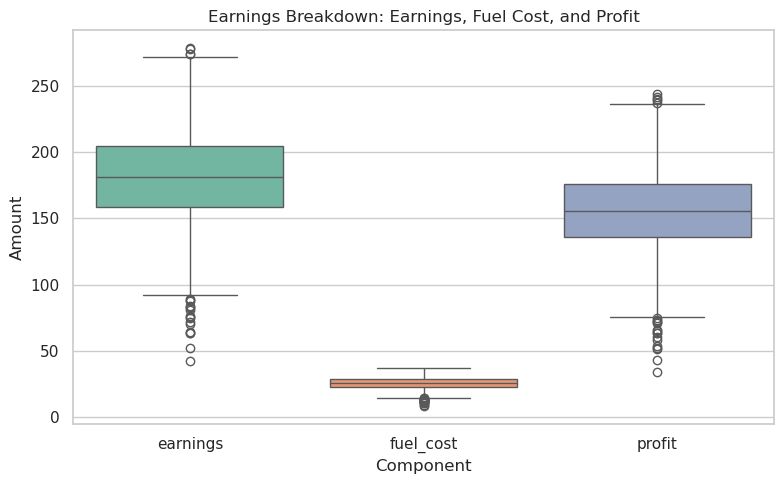

Time columns for breakdown: ['total_pickup_time', 'total_dropoff_time', 'total_waiting_point_travel_time', 'total_idling_time']


/tmp/ipykernel_361232/4056311542.py:127: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Time Category', y='Time', data=melt_time, palette='Set3')


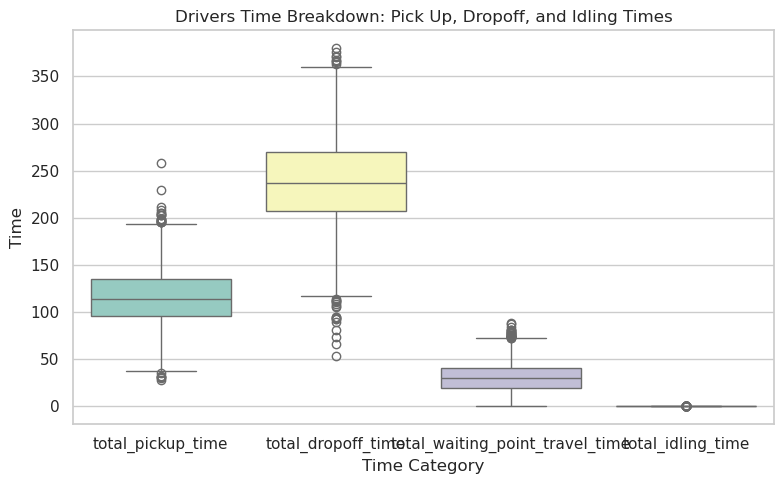

/tmp/ipykernel_361232/4056311542.py:150: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Distance Category', y='Distance', data=melt_distance, palette='Set2')


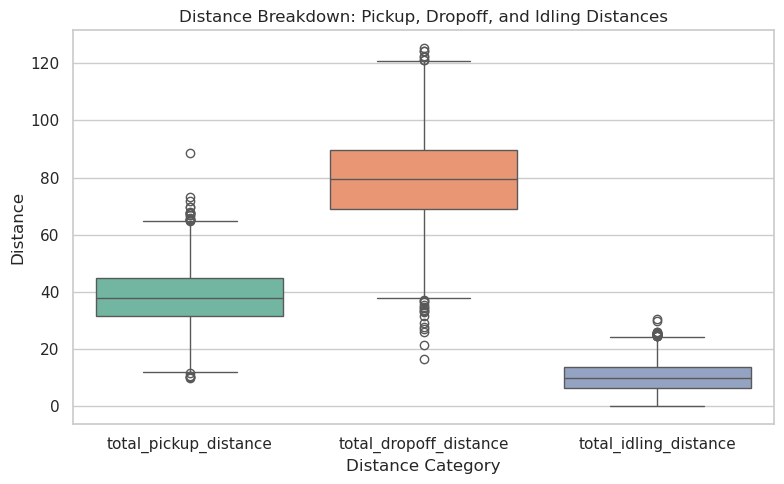

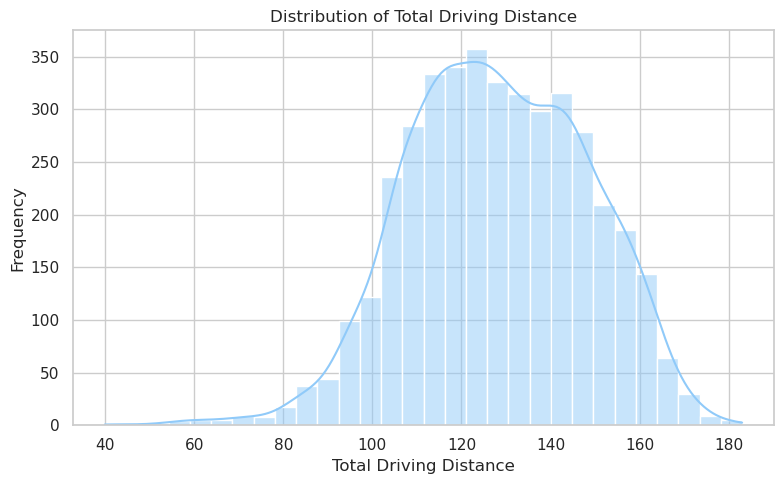

/tmp/ipykernel_361232/4056311542.py:171: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette=['#FFB74D', '#81C784', '#64B5F6', '#BA68C8'])
/tmp/ipykernel_361232/4056311542.py:171: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.barplot(x=metrics, y=values, palette=['#FFB74D', '#81C784', '#64B5F6', '#BA68C8'])


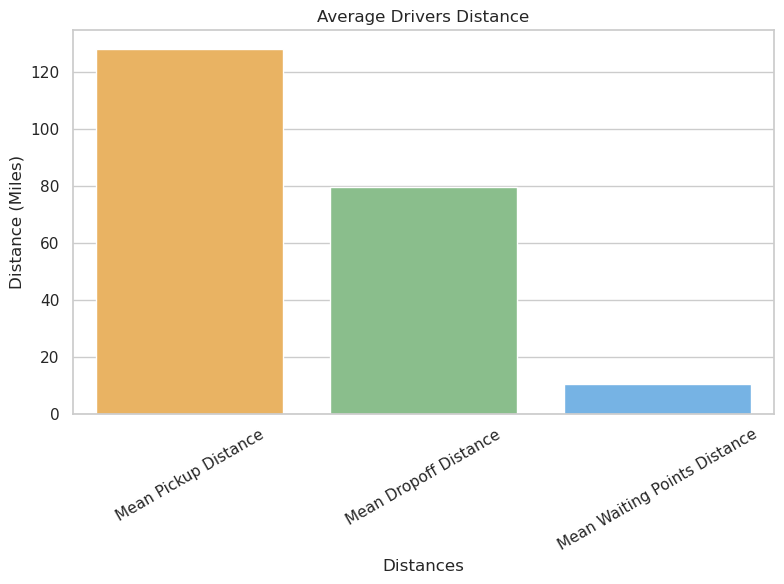

Average Earning: 181.80448721418682
Average Profit: 156.17918087059738
Average Fuel Cost: 25.625306343589504


/tmp/ipykernel_361232/4056311542.py:204: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics, y=values, palette=['#90CAF9', '#FFA726', '#66BB6A', '#FFCC80'][:len(metrics)])


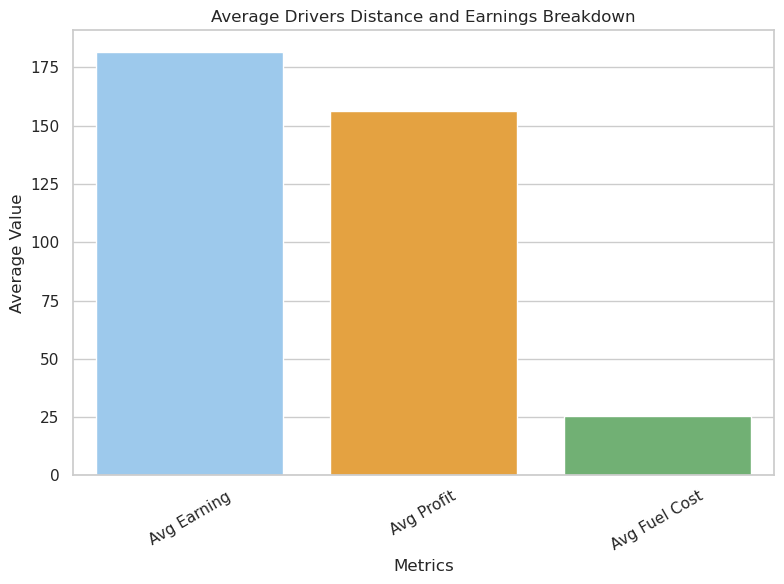

In [35]:
drivers_df, filtered_drivers_df = drivers_analysis(drivers_df)

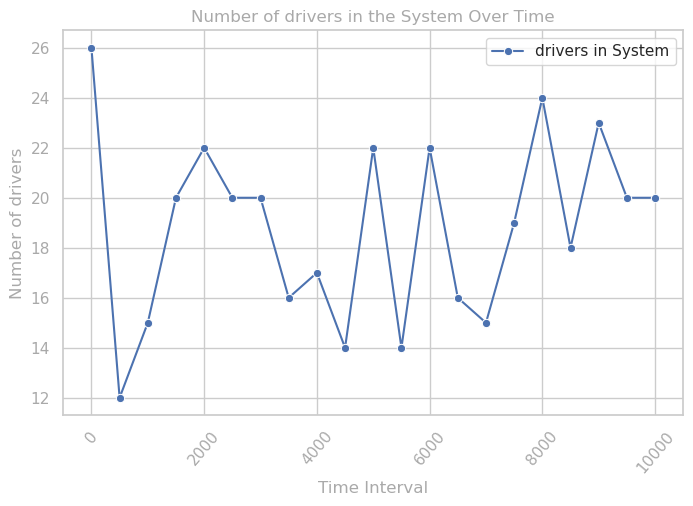

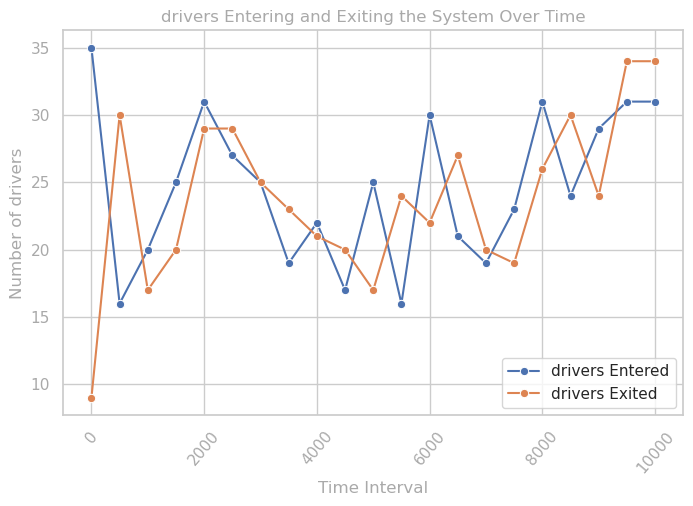

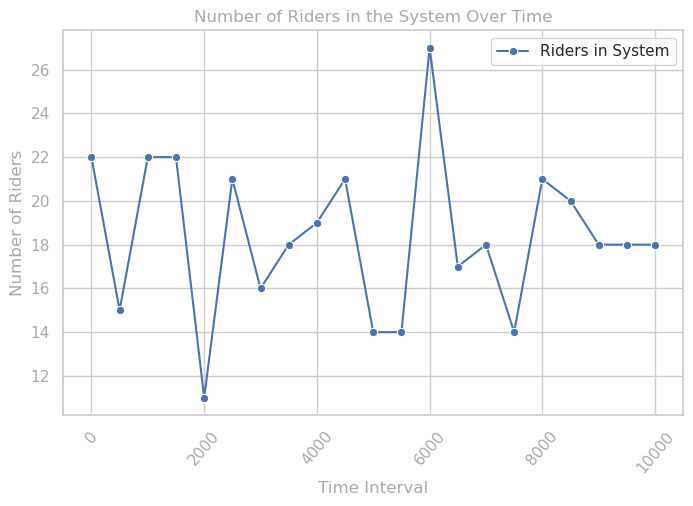

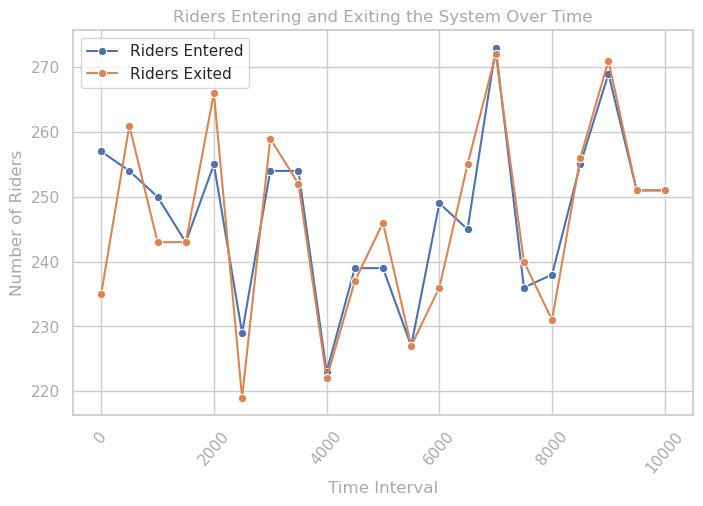

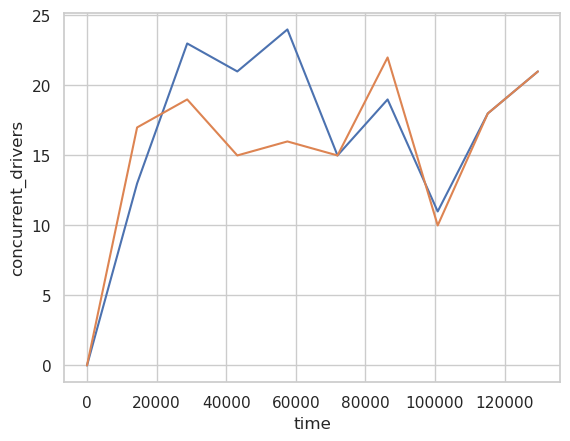

In [36]:
system_analysis(riders_df, drivers_df, concurrent_df)